In [1]:
import random

import numpy as np
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import torchvision.transforms.functional as F
import segmentation_models_pytorch as smp

from utils import (
    evaluate_model,
    plot_image_mask,
    train,
)


USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda:0" if USE_CUDA else "cpu")


def set_figure_size(figsize=(8, 6), dpi=120):
    plt.figure(figsize=figsize, dpi=dpi)


seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)

In [2]:
class TargetTransform:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, mask):
        mask = self.transform(mask)
        mask = torch.where(mask != 0, torch.tensor(1.0), mask)
        return mask


transform = transforms.Compose([transforms.Resize((512, 512)), transforms.ToTensor()])
target_transform = TargetTransform(transform)

train_dataset = torchvision.datasets.VOCSegmentation(
    "dataset/",
    image_set="train",
    transform=transform,
    target_transform=target_transform,
    download=False,
    year="2012",
)
val_dataset = torchvision.datasets.VOCSegmentation(
    "dataset/",
    image_set="val",
    transform=transform,
    target_transform=target_transform,
    download=False,
    year="2012",
)

train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=8, shuffle=True, drop_last=True
)
val_dataloader = torch.utils.data.DataLoader(
    dataset=val_dataset, batch_size=8, shuffle=False
)

In [ ]:
for i in range(5):
    img, mask = val_dataset[i]
    plot_image_mask(img, mask)

In [3]:
model = smp.UnetPlusPlus(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation="sigmoid",
)
model.to(device)

UnetPlusPlus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

Проверим качество предобученной модели

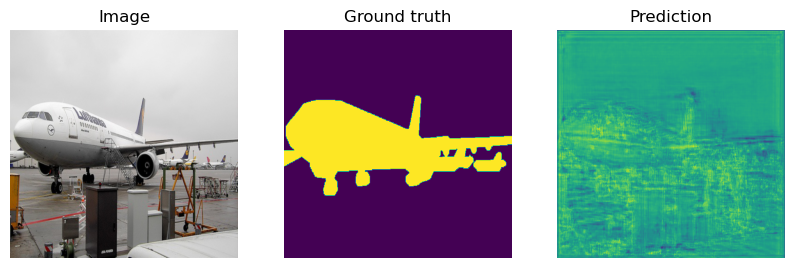

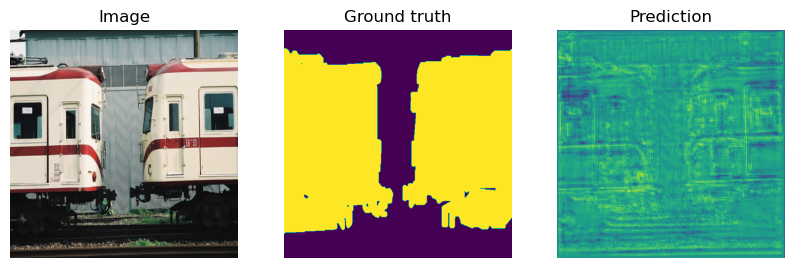

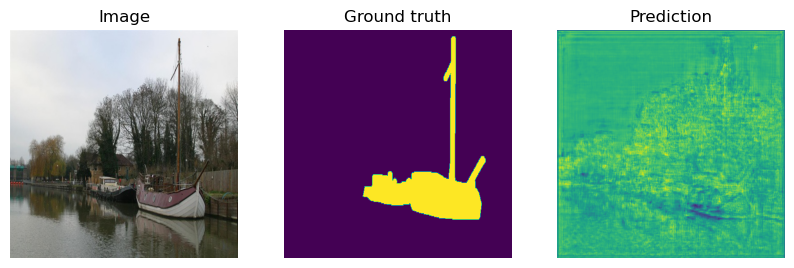

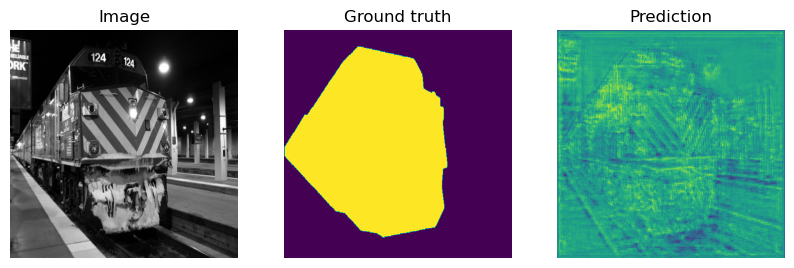

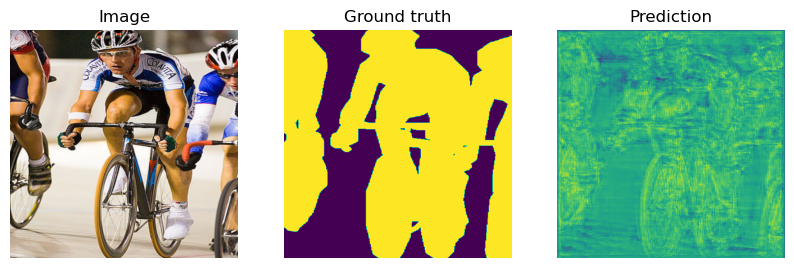

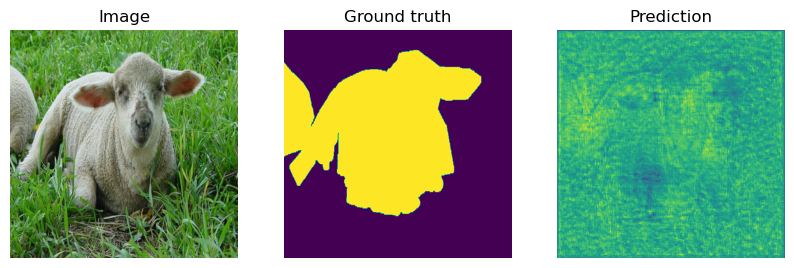

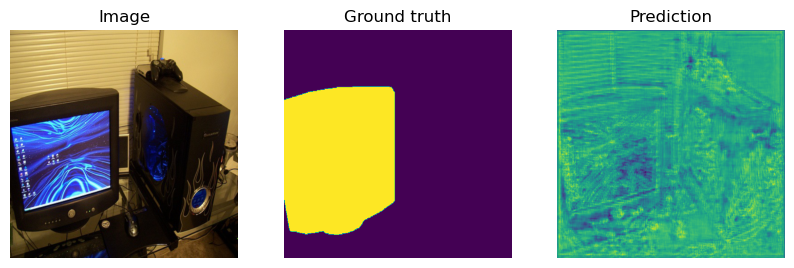

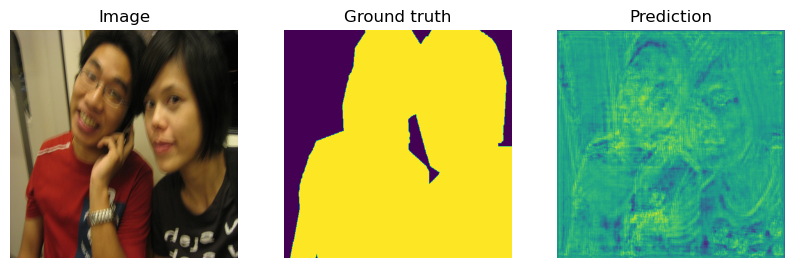

In [5]:
batch = next(iter(val_dataloader))

input, mask = batch
input = input.to(device)
mask = mask.to(device)

with torch.no_grad():
    model.eval()
    logits = model(input)
pr_masks = logits.sigmoid()

for image, gt_mask, pr_mask in zip(input, mask, pr_masks):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.cpu().detach().numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.cpu().detach().numpy().squeeze())
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.cpu().detach().numpy().squeeze())
    plt.title("Prediction")
    plt.axis("off")

    plt.show()

In [6]:
print(
    f"mIoU score: {evaluate_model(model, val_dataloader, threshold=0.5, device=device)}"
)

100%|██████████| 182/182 [00:21<00:00,  8.41it/s]

mIoU score: 0.30577611923217773


Перейдем к обучению модели

In [7]:
model = smp.UnetPlusPlus(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation="sigmoid",
)
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
loss_fn = nn.BCELoss()

train(
    model=model,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    num_epochs=3,
    device=device,
    scheduler=None,
)

100%|██████████| 182/182 [00:21<00:00,  8.62it/s]


Epoch: 0, Train Loss: 0.42048460245132446, Val Loss: 0.36263200640678406
IOU score: 0.5786808729171753


100%|██████████| 182/182 [00:21<00:00,  8.59it/s]


Epoch: 1, Train Loss: 0.3173442482948303, Val Loss: 0.37140363454818726
IOU score: 0.5353730916976929


100%|██████████| 182/182 [00:21<00:00,  8.52it/s]

Epoch: 2, Train Loss: 0.2893083095550537, Val Loss: 0.32236722111701965
IOU score: 0.6136320233345032


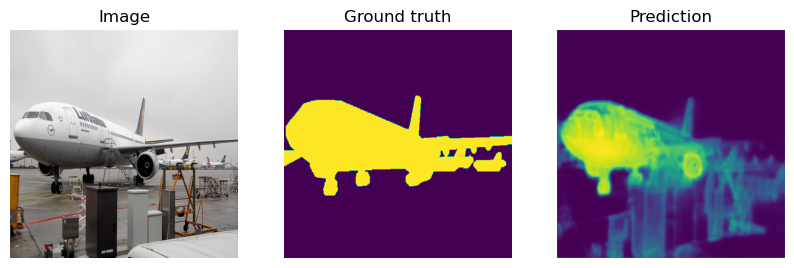

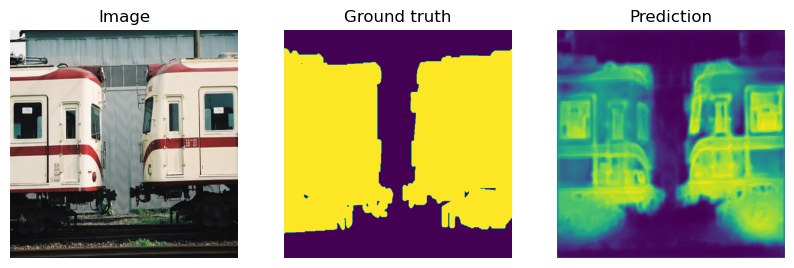

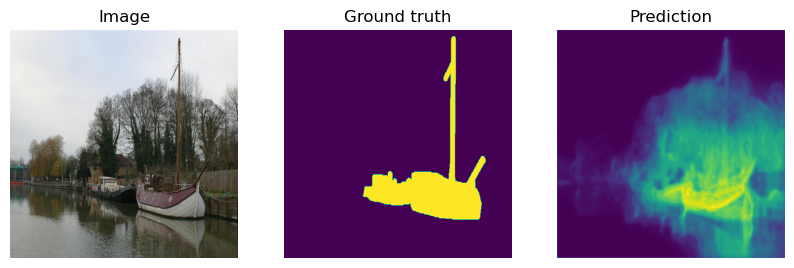

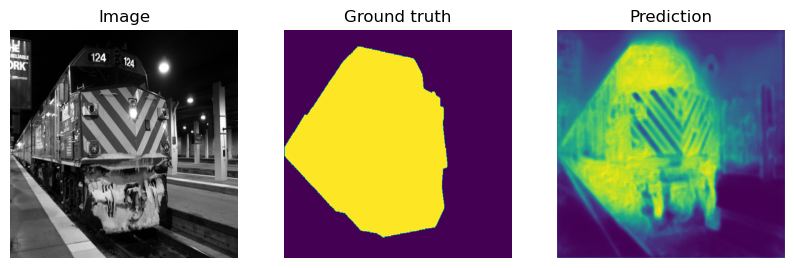

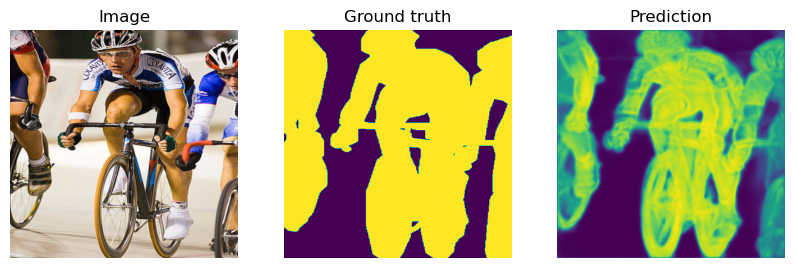

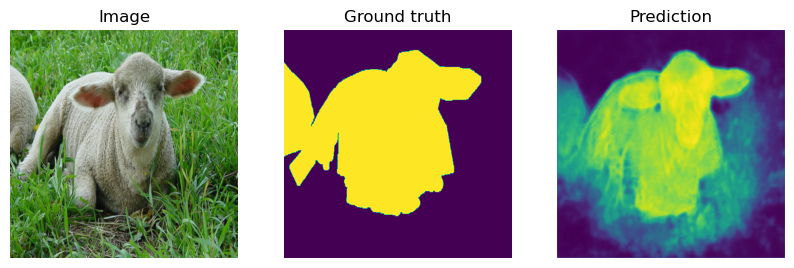

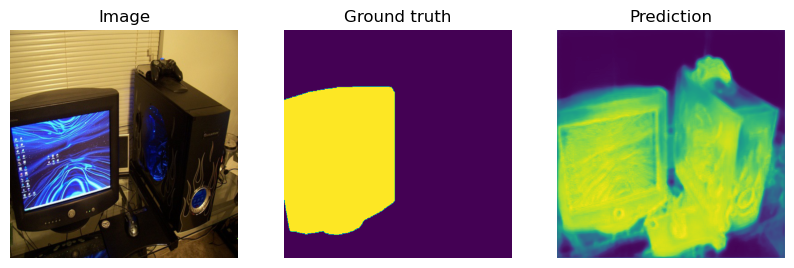

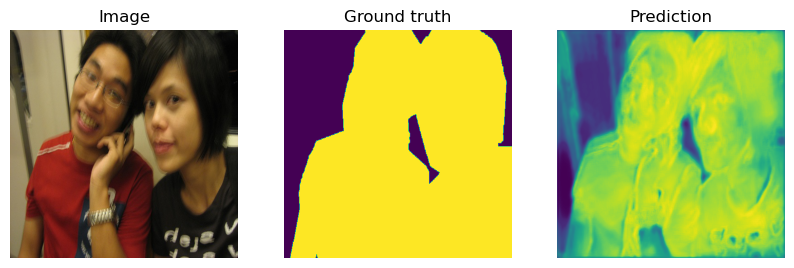

In [8]:
batch = next(iter(val_dataloader))

input, mask = batch
input = input.to(device)
mask = mask.to(device)

with torch.no_grad():
    model.eval()
    logits = model(input)
pr_masks = logits.sigmoid()

for image, gt_mask, pr_mask in zip(input, mask, pr_masks):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.cpu().detach().numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.cpu().detach().numpy().squeeze())
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.cpu().detach().numpy().squeeze())
    plt.title("Prediction")
    plt.axis("off")

    plt.show()

Добавим аугментации

In [9]:
train_transform = transforms.Compose(
    [
        transforms.Resize((512, 512)),
        transforms.ColorJitter(brightness=0.5, hue=0.3),
        transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.0)),
        transforms.ToTensor(),
    ]
)
val_transforms = transforms.Compose(
    [
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
    ]
)
target_transform = TargetTransform(transform)

train_dataset = torchvision.datasets.VOCSegmentation(
    "dataset/",
    image_set="train",
    transform=train_transform,
    target_transform=target_transform,
    download=False,
    year="2012",
)
val_dataset = torchvision.datasets.VOCSegmentation(
    "dataset/",
    image_set="val",
    transform=val_transforms,
    target_transform=target_transform,
    download=False,
    year="2012",
)

train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=8, shuffle=True, drop_last=True
)
val_dataloader = torch.utils.data.DataLoader(
    dataset=val_dataset, batch_size=8, shuffle=False
)

In [11]:
model = smp.UnetPlusPlus(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation="sigmoid",
)
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
loss_fn = nn.BCELoss()

train(
    model=model,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    num_epochs=3,
    device=device,
    scheduler=None,
)

100%|██████████| 182/182 [00:27<00:00,  6.58it/s]


Epoch: 0, Train Loss: 0.4294474720954895, Val Loss: 0.4058358371257782
IOU score: 0.5898414850234985


100%|██████████| 182/182 [00:27<00:00,  6.70it/s]


Epoch: 1, Train Loss: 0.36261093616485596, Val Loss: 0.34239229559898376
IOU score: 0.6167556047439575


100%|██████████| 182/182 [00:27<00:00,  6.69it/s]

Epoch: 2, Train Loss: 0.3320346176624298, Val Loss: 0.3641495704650879
IOU score: 0.5421320796012878


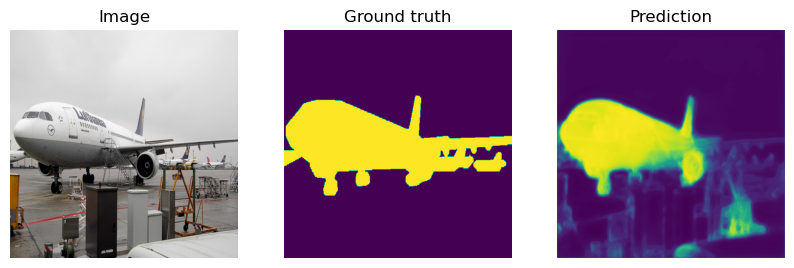

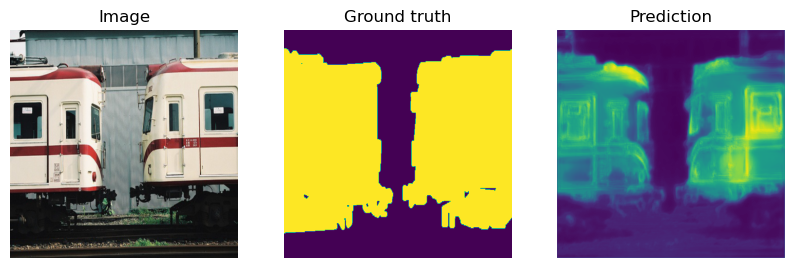

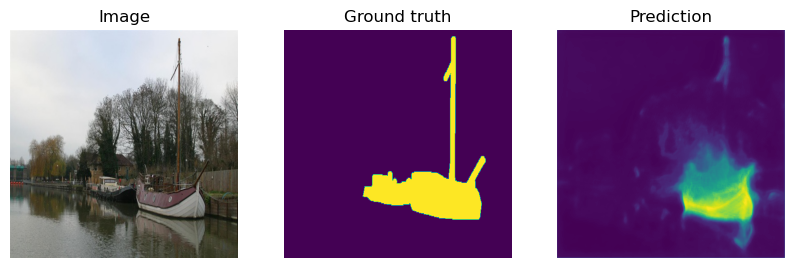

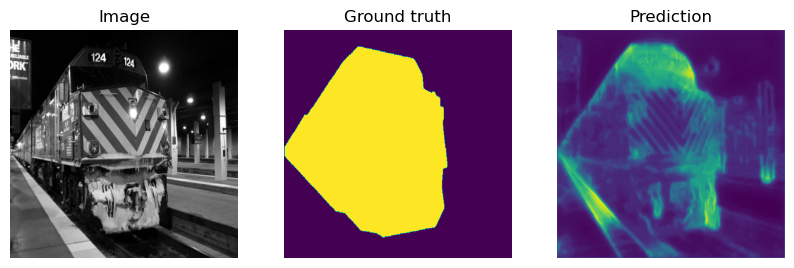

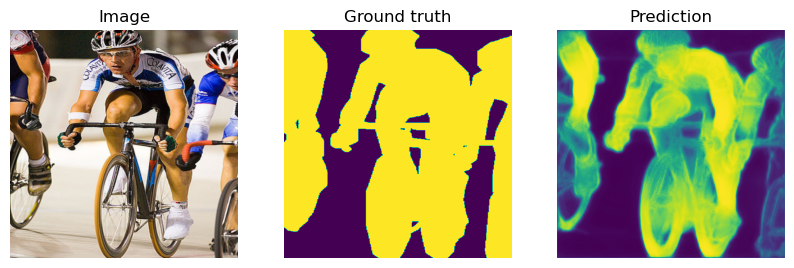

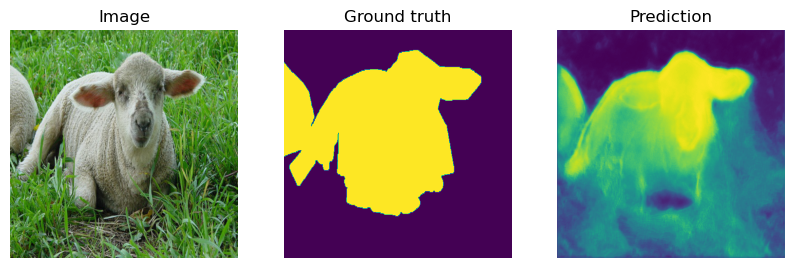

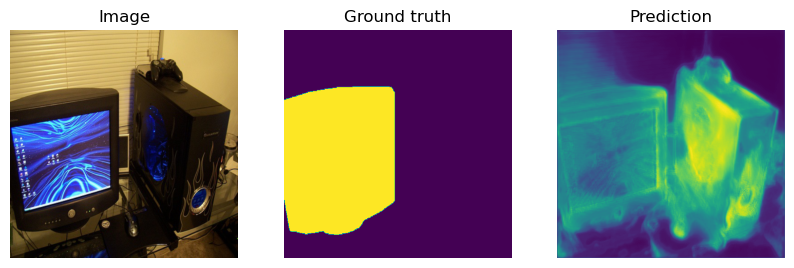

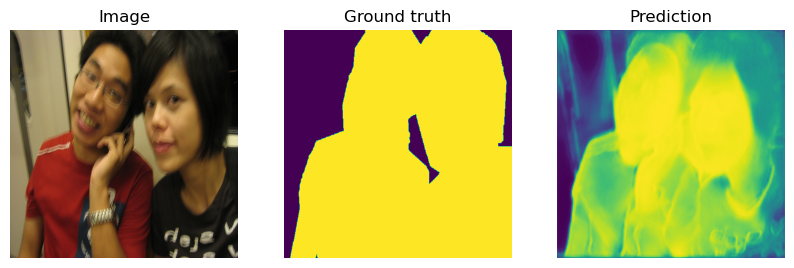

In [12]:
batch = next(iter(val_dataloader))

input, mask = batch
input = input.to(device)
mask = mask.to(device)

with torch.no_grad():
    model.eval()
    logits = model(input)
pr_masks = logits.sigmoid()

for image, gt_mask, pr_mask in zip(input, mask, pr_masks):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.cpu().detach().numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.cpu().detach().numpy().squeeze())
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.cpu().detach().numpy().squeeze())
    plt.title("Prediction")
    plt.axis("off")

    plt.show()

Добавим Dice Loss

In [13]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, pred, target):
        pred = pred.view(-1)
        target = target.view(-1)

        intersection = torch.sum(pred * target)
        union = torch.sum(pred) + torch.sum(target)

        dice_score = (2.0 * intersection + self.smooth) / (union + self.smooth)
        dice_loss = 1.0 - dice_score

        return dice_loss


class SumOfLosses(nn.Module):
    def __init__(self, l1, l2):
        super(SumOfLosses, self).__init__()
        self.l1 = l1
        self.l2 = l2

    def __call__(self, *inputs):
        return self.l1.forward(*inputs) + self.l2.forward(*inputs)

In [14]:
model = smp.UnetPlusPlus(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation="sigmoid",
)
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
loss_fn = SumOfLosses(nn.BCELoss(), DiceLoss())

train(
    model=model,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    num_epochs=3,
    device=device,
    scheduler=None,
)

100%|██████████| 182/182 [00:20<00:00,  8.68it/s]


Epoch: 0, Train Loss: 0.8251059055328369, Val Loss: 0.6903230547904968
IOU score: 0.5916780233383179


100%|██████████| 182/182 [00:21<00:00,  8.61it/s]


Epoch: 1, Train Loss: 0.696710467338562, Val Loss: 0.6645117402076721
IOU score: 0.6217651963233948


100%|██████████| 182/182 [00:20<00:00,  8.71it/s]

Epoch: 2, Train Loss: 0.6421265006065369, Val Loss: 0.6087254285812378
IOU score: 0.6318191289901733


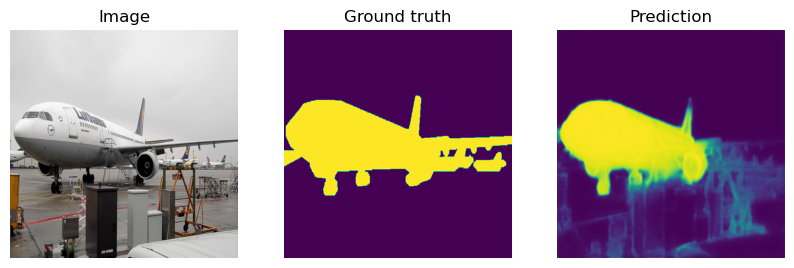

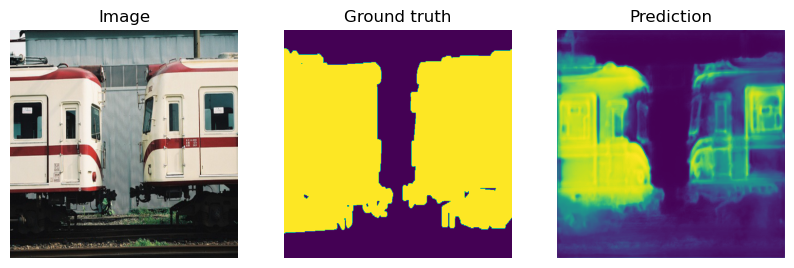

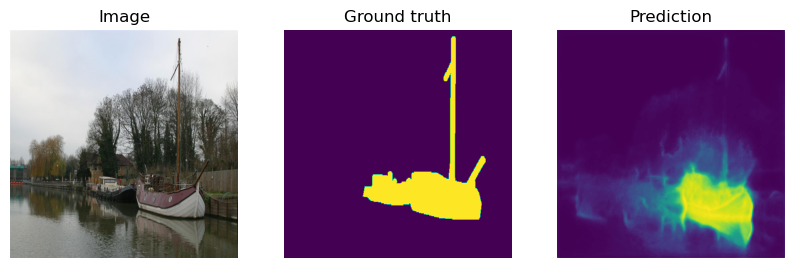

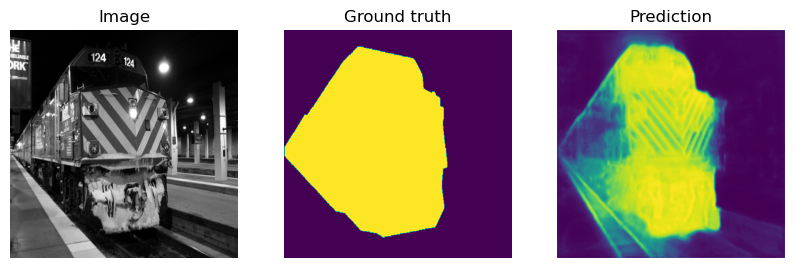

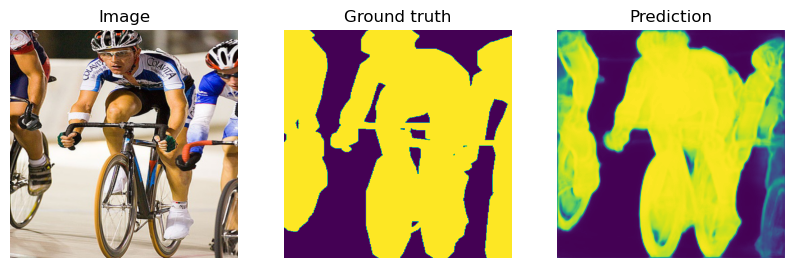

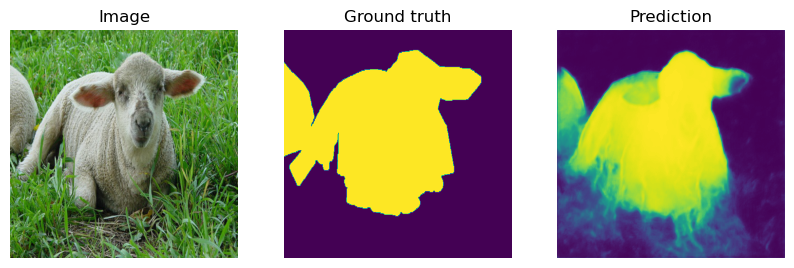

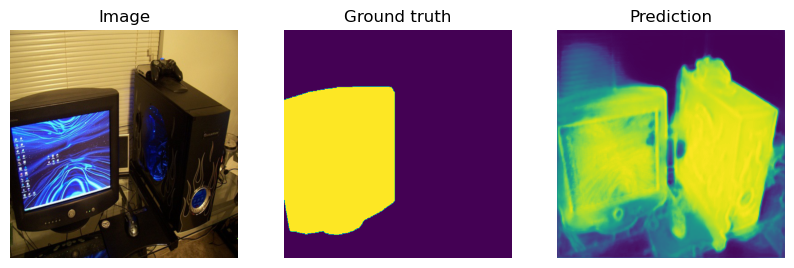

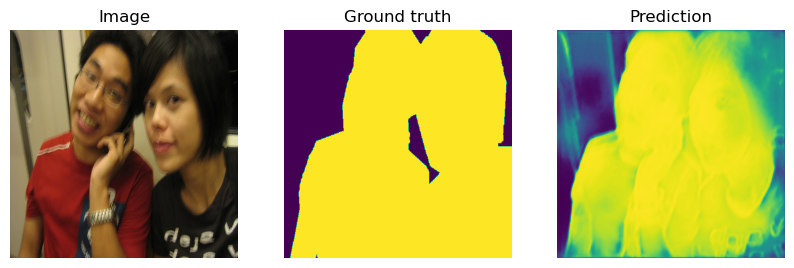

In [16]:
batch = next(iter(val_dataloader))

input, mask = batch
input = input.to(device)
mask = mask.to(device)

with torch.no_grad():
    model.eval()
    logits = model(input)
pr_masks = logits.sigmoid()

for image, gt_mask, pr_mask in zip(input, mask, pr_masks):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.cpu().detach().numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.cpu().detach().numpy().squeeze())
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.cpu().detach().numpy().squeeze())
    plt.title("Prediction")
    plt.axis("off")

    plt.show()

Выводы:
- Предобученная модель достаточно плохо отделяет объекты от фона.
- По сравнению с предобученной моделью удалось повысить качество в 2 раза с 0.3 mean-IoU до 0.6 mean-IoU.
- Добавление аугментаций позволило немного увеличить скор.
- Добавление Dice Loss позволило увеличить скор, а также установить более монотонную сходимость.
- AdamW с lr=3e-4 показал наиболее лучшее качество по сравнению с SGD и Adam.

Что можно улучшить:
- В связи с проведением большого количества экспериментов было использовано небольшое число эпох. Плато достигнуто не было, поэтому увеличение количества эпох скорее всего приведет к повышению качества.
- Также следует добавить шедулер, поскольку наблюдались флуктуации по метрикам и лоссам во время обучения.
- Подобрать параметры для суммы лосс функций.
- Использовать более сложный энкодер в сети, например, ResNest, который использует различные механизмы внимания.